# 1.1 Setup a Folder:

---






In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import os
if not os.path.isdir("SkinCancer"):
  os.makedirs("SkinCancer")
%cd SkinCancer

/content/drive/MyDrive/SkinCancer


## 1.2 Donwloading DataSet:

---





In [ ]:
!pip install opendatasets
import opendatasets as od
if not os.path.isdir("ham1000-segmentation-and-classification"):
  od.download("https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ahmedghida
Your Kaggle Key: ··········


100%|██████████| 2.59G/2.59G [00:21<00:00, 127MB/s]


## 2.1 Exploring & Visualize The Data:

---






(-0.5, 299.5, 299.5, -0.5)

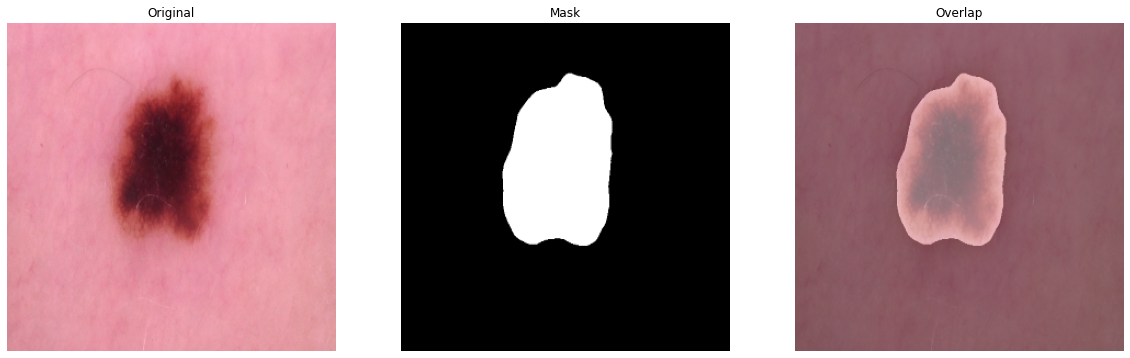

In [ ]:
import glob as gb
import cv2
import numpy as np 
import matplotlib.pyplot as plt

names=[(file.split("/")[2]).split(".")[0] for file in gb.glob("ham1000-segmentation-and-classification/images/*.jpg")]

index=np.random.randint(len(names))
Size=300

image=cv2.imread("ham1000-segmentation-and-classification/images/{}.jpg".format(names[index]))
image=cv2.resize(image,(Size,Size))
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask=cv2.imread("ham1000-segmentation-and-classification/masks/{}.png".format(names[index]+"_segmentation"))
mask=cv2.resize(mask,(Size,Size))
mask=cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)

#Vizalizing:
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.imshow(image)
plt.title("Original")
plt.axis('off')

plt.subplot(132)
plt.imshow(mask)
plt.title("Mask")
plt.axis('off')

plt.subplot(133)
plt.imshow(image)
plt.imshow(mask,alpha=.4)
plt.title("Overlap")
plt.axis('off')


In [ ]:
print("The Number Of Images And Masks: ",str(len(names)))

The Number Of Images And Masks:  10015


##### Splitting Data:

In [ ]:
from sklearn.model_selection import train_test_split

masksnames=names

X_train,X_test,ytrain,ytest=train_test_split(names,masksnames,test_size=.1,shuffle=True)
X_train,X_Val,ytrain,yval=train_test_split(X_train,ytrain,test_size=.11,shuffle=True)

In [ ]:
## lets Creat Folders
import shutil as sh
from tqdm import tqdm 
#for Imgaes:
print("For Images: ")
for i in tqdm(names):
  if i in X_train:
    path2save="Train"
  elif i in X_Val:
    path2save="Val"
  else:
    path2save="Test"
  if not os.path.isdir(f"ham1000-segmentation-and-classification/{path2save}/images"):
         os.makedirs(f"ham1000-segmentation-and-classification/{path2save}/images")
  sh.move((f"ham1000-segmentation-and-classification/images/{i}.jpg"),(f"ham1000-segmentation-and-classification/{path2save}/images/{i}.jpg"))


print("For Masks: ")
#for Imgaes:
for i in tqdm(names):
  if i in X_train:
    path2save="Train"
  elif i in X_Val:
    path2save="Val"
  else:
    path2save="Test"
  if not os.path.isdir(f"ham1000-segmentation-and-classification/{path2save}/masks"):
         os.makedirs(f"ham1000-segmentation-and-classification/{path2save}/masks")
  sh.move((f"ham1000-segmentation-and-classification/masks/{i}_segmentation.png"),(f"ham1000-segmentation-and-classification/{path2save}/masks/{i}_segmentation.png"))

For Images: 


100%|██████████| 10015/10015 [00:40<00:00, 245.19it/s]


For Masks: 


100%|██████████| 10015/10015 [01:16<00:00, 131.73it/s]


##2.2 Data Loading :
---


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
#for training data:
train_images_datagen = ImageDataGenerator(rescale=1./255)
train_mask_datagen = ImageDataGenerator(rescale=1./255)
B_size=16
seed = 2
train_path="ham1000-segmentation-and-classification/Train"
image_generator =train_images_datagen.flow_from_directory(
    train_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    batch_size=B_size,
    target_size=(Size,Size))

mask_generator = train_mask_datagen.flow_from_directory(
    train_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    color_mode="grayscale",
    batch_size=B_size,
    target_size=(Size,Size))
# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 8021 images belonging to 1 classes.
Found 8021 images belonging to 1 classes.


In [ ]:
#for validation data:

image_datagen=ImageDataGenerator(rescale=1./255)
mask_datagen=ImageDataGenerator(rescale=1./255)
Val_path="ham1000-segmentation-and-classification/Val"
val_image_generator = image_datagen.flow_from_directory(
    Val_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    batch_size=B_size,
    target_size=(Size,Size))

val_mask_generator = mask_datagen.flow_from_directory(
    Val_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    color_mode='grayscale',
    target_size=(Size,Size))

# combine generators into one which yields image and masks
val_generator = zip(val_image_generator, val_mask_generator)

Found 992 images belonging to 1 classes.
Found 992 images belonging to 1 classes.


# 3.1 Create Model:

---



In [ ]:
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import load_img,img_to_array,plot_model 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint,EarlyStopping,Callback
from tensorflow.keras.layers import Conv2DTranspose,ZeroPadding2D,Conv2D,add,Dropout,Input,concatenate,Activation,MaxPooling2D,UpSampling2D

In [ ]:
def decoder_block(input,skip_features, num_filters,conv_padding=False,zero_pad=False):

    x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(input)
    x=  UpSampling2D(size = (2,2))(x)

    if zero_pad == True:
      x=ZeroPadding2D((1,1))(x)
    
    if conv_padding ==True:
        x=Conv2D(num_filters, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(x)
    else:
        x=Conv2D(num_filters, 2, activation = 'relu', kernel_initializer = 'he_normal')(x)
    x=Dropout(.2)(x)
   
    x = concatenate([x, skip_features],axis=-1)
    

    return x

In [ ]:
def Unet(input_size,n_classes):
    """ Input """
    inp = Input(input_size)
    """ Encoder """
    Basemodel= VGG19(include_top=False, weights='imagenet', input_tensor=inp)

    E0=Basemodel.get_layer("block1_conv2").output 
    E1=Basemodel.get_layer("block2_conv2").output 
    E2=Basemodel.get_layer("block3_conv4").output 
    E3=Basemodel.get_layer("block4_conv4").output
    E4=Basemodel.get_layer("block5_conv4").output    

    """bridge"""
    E5=Basemodel.get_layer("block5_pool").output
    
    """ Decoder """

    D1=decoder_block(E5,E4,512,conv_padding=True)
    D2=decoder_block(D1,E3,512,zero_pad=True)
    D3=decoder_block(D2,E2,256,zero_pad=True)
    D4=decoder_block(D3,E1,128,conv_padding=True)
    D5=decoder_block(D3,E1,64,conv_padding=True)


    D5=UpSampling2D(size = (2,2))(D4)
    D5=Conv2D(64, 3, activation = 'relu', padding='same', kernel_initializer = 'he_normal')(D5)


    """ OutPut """
    Output=Conv2D(n_classes, 1, activation = 'sigmoid')(D5)
    
    model = Model(inp,Output, name="Unet")
    model.summary()
    return model

In [ ]:
model=Unet((300,300,3),1)

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 300, 300, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 300, 300, 64  36928       ['block1_conv1[0][0]']           
                                )                                                              

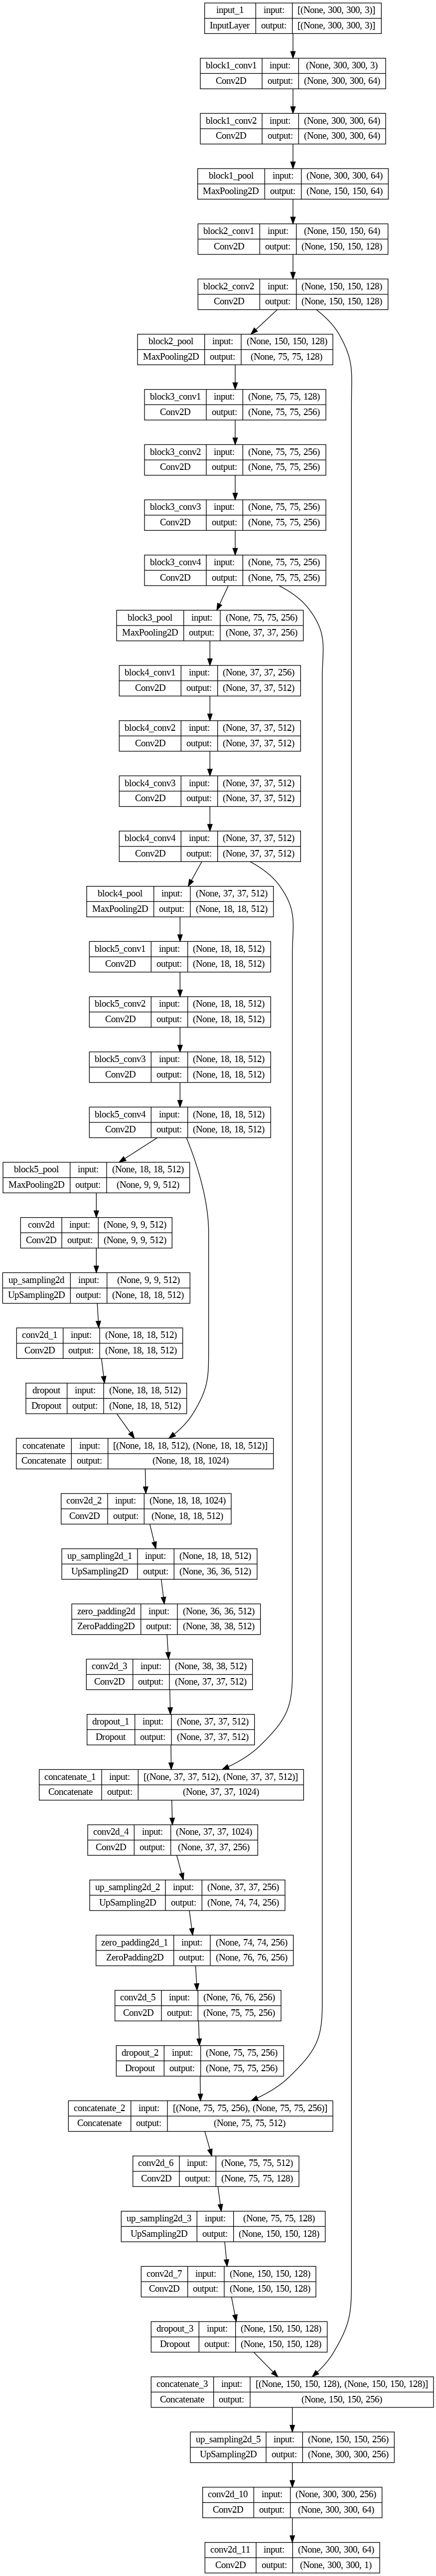

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,expand_nested=True)

# 3.2 Compilation & Trainning:

---



In [ ]:
model.compile(optimizer = Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model_checkpoint = ModelCheckpoint('skin_cancer.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=6, min_lr=1e-9)
Earlystop=EarlyStopping(monitor="val_loss",patience=14,mode="auto",restore_best_weights=True)

In [ ]:
class Viz_process(Callback):  
    def on_epoch_end(self, epoch, logs=None):
        # Select a random sample from the validation set
        image_batch, label_batch = next(iter(val_generator))
        idx=np.random.randint(image_batch.shape[0])
        image,label=image_batch[idx],label_batch[idx]

        # Get predicted label
        pred_label = np.squeeze(self.model.predict(np.expand_dims(image, axis=0)),axis=0)
        
        ### Display the image, true label, and predicted label
        plt.figure(figsize=(18,9))
        plt.subplot(131)
        plt.imshow(image)
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(label)
        plt.axis('off')
        plt.title('Label')   
        plt.subplot(133)
        plt.imshow(pred_label)
        plt.axis('off')
        plt.title('Pred_Label')
        plt.show()

Epoch 1/50
1/1 [==============================] - 1s 1s/step


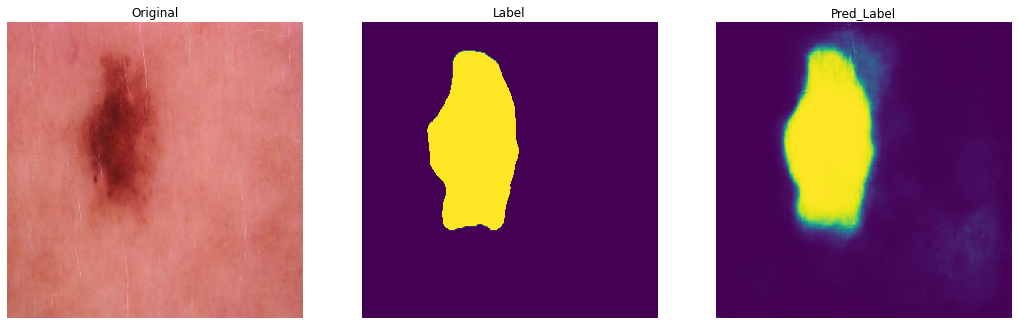


Epoch 1: val_loss improved from inf to 0.11760, saving model to skin_cancer.hdf5
501/501 [==============================] - 638s 1s/step - loss: 0.1938 - accuracy: 0.9302 - val_loss: 0.1176 - val_accuracy: 0.9544 - lr: 1.0000e-04
Epoch 2/50
1/1 [==============================] - 0s 22ms/step


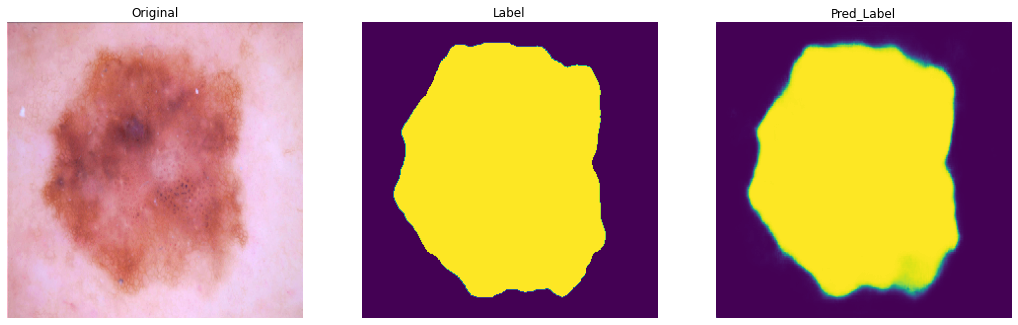


Epoch 2: val_loss improved from 0.11760 to 0.10045, saving model to skin_cancer.hdf5
501/501 [==============================] - 633s 1s/step - loss: 0.1135 - accuracy: 0.9564 - val_loss: 0.1004 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 3/50
1/1 [==============================] - 0s 23ms/step


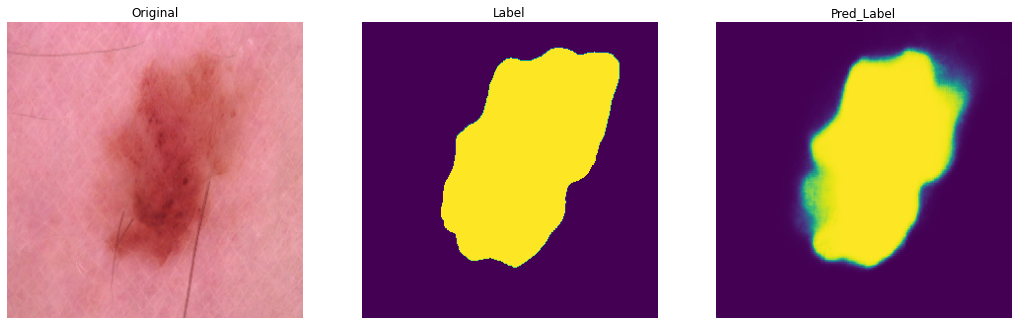


Epoch 3: val_loss did not improve from 0.10045
501/501 [==============================] - 619s 1s/step - loss: 0.1062 - accuracy: 0.9588 - val_loss: 0.1009 - val_accuracy: 0.9605 - lr: 1.0000e-04
Epoch 4/50
1/1 [==============================] - 0s 23ms/step


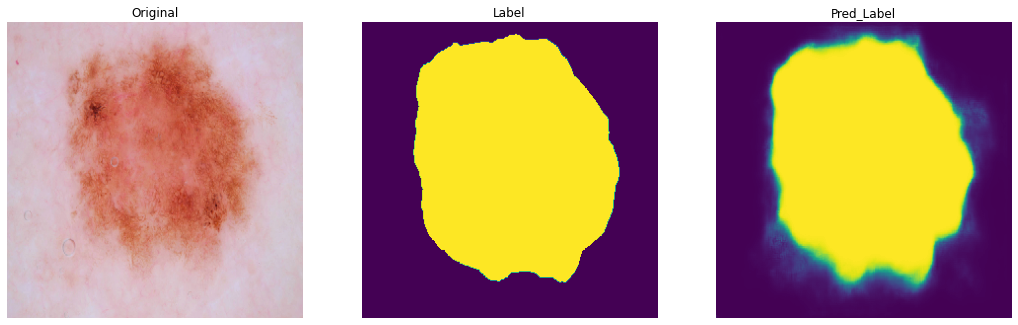


Epoch 4: val_loss did not improve from 0.10045
501/501 [==============================] - 620s 1s/step - loss: 0.1031 - accuracy: 0.9600 - val_loss: 0.1123 - val_accuracy: 0.9548 - lr: 1.0000e-04
Epoch 5/50
 28/501 [>.............................] - ETA: 9:13 - loss: 0.0978 - accuracy: 0.9625

KeyboardInterrupt: ignored

In [ ]:
epochs=50
steps=int(8021/B_size)
valid_steps=int(992/B_size)

Hisotry=model.fit(train_generator,
        validation_data=val_generator,
        steps_per_epoch=steps,
        validation_steps=valid_steps,
        epochs=epochs,
        callbacks=[Viz_process(),model_checkpoint,reduce_lr,Earlystop])


# 3.3 Evaluation & Predicitions:

---



In [ ]:
#for validation data:

image_datagen=ImageDataGenerator(rescale=1./255)
mask_datagen=ImageDataGenerator(rescale=1./255)
test_path="ham1000-segmentation-and-classification/Test"
test_image_generator = image_datagen.flow_from_directory(
    Val_path,
    class_mode=None,
    classes=['images'],
    seed=seed,
    batch_size=B_size,
    target_size=(Size,Size))

test_mask_generator = mask_datagen.flow_from_directory(
    Val_path,
    classes=['masks'],
    class_mode=None,
    seed=seed,
    batch_size=B_size,
    color_mode='grayscale',
    target_size=(Size,Size))

# combine generators into one which yields image and masks
test_generator = zip(test_image_generator, test_mask_generator)

Found 992 images belonging to 1 classes.
Found 992 images belonging to 1 classes.


In [ ]:
model.evaluate(test_generator,steps=int(992/B_size))

62/62 [==============================] - 20s 322ms/step - loss: 0.1006 - accuracy: 0.9603


[0.10061891376972198, 0.9602944254875183]

1/1 [==============================] - 0s 63ms/step


Text(0.5, 1.0, 'original+pred')

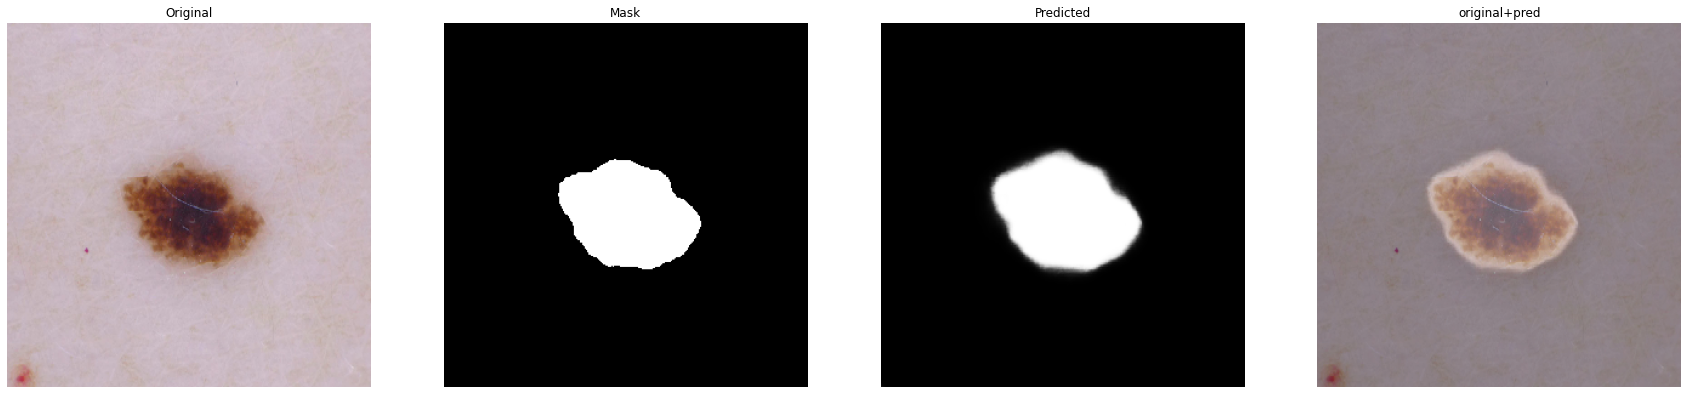

In [ ]:
image,mask=next(test_generator)
indx=np.random.randint(image.shape[0])
image,mask=image[indx],mask[indx]
img=np.expand_dims(image,axis=0)
result=model.predict(img)
result=np.squeeze(result,axis=0)

plt.figure(figsize=(30,22))
plt.subplot(141)
plt.imshow(image)
plt.axis('off')
plt.title("Original")
plt.subplot(142)
plt.imshow(mask,cmap='gray')
plt.axis('off')
plt.title("Mask")
plt.subplot(143)
plt.imshow(result,cmap='gray')
plt.axis('off')
plt.title("Predicted")
plt.subplot(144)
plt.imshow(image)
plt.imshow(result,alpha=.3,cmap="gray")
plt.axis('off')
plt.title("original+pred")